In [1]:
import sys
import time

import numpy as np
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import EditedNearestNeighbours, InstanceHardnessThreshold, ClusterCentroids, RepeatedEditedNearestNeighbours

import torch
import torchvision.transforms as T

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] 
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False 


sys.path.append("/home/zhouquan/MyDoc/Deep_Learning/My_TAOD/dataset")
from dataset_loader import get_loader
sys.path.append("/home/zhouquan/MyDoc/Deep_Learning/My_Filter")
from Feature_Extractor import select_feature_extractor

In [2]:
FE = select_feature_extractor('vgg19')
FE.eval()

trans = T.Compose([T.ToTensor(), T.Resize((256, 256))])
data_path = "/home/zhouquan/MyDoc/Deep_Learning/My_TAOD/TA/TA_Results/CycleGAN/DeepPCB_Crop[10-shot]<-PCB_200[200-shot].csv"
data_loader = get_loader(data_path, 128, 4, shuffle=False, trans=trans, dataset_class="DeepPCB_Crop", require_path=True)

device = "cuda:1"

FE.to(device)

start_time = time.time()

for batch_idx, (X, y, img_path) in enumerate(data_loader):
    
    X = X.to(device)
    batch_X_data = FE(X)
    batch_X_data = batch_X_data.detach().cpu()
    batch_y = y
    batch_path = img_path
    
    if batch_idx == 0:
        data_X = batch_X_data
        data_y = batch_y
        data_path = batch_path
    else:
        data_X = torch.cat((data_X, batch_X_data), dim=0)
        data_y = torch.cat((data_y, batch_y), dim=0)
        data_path += batch_path

cost_time = time.time() - start_time

data_X = data_X.numpy()
data_y = data_y.numpy()


print(f"特征提取: 样本数：{len(data_path)} 耗时:{cost_time:.3f}")

print(f"\
类别为 0 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 1 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 2 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 3 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 4 的样本数: {np.count_nonzero(data_y == 0)}\n\
    ")


def plt_tsne2d(X, Y, title="t-SNE"):
    # tsne
    tsne = TSNE()
    X_tsne = tsne.fit_transform(X)
    # 归一化
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    X_tsne = scaler.fit_transform(X_tsne)
    
    index0 = [i for i in range(len(Y)) if Y[i] == 0]
    index1 = [i for i in range(len(Y)) if Y[i] == 1]
    index2 = [i for i in range(len(Y)) if Y[i] == 2]
    index3 = [i for i in range(len(Y)) if Y[i] == 3]
    index4 = [i for i in range(len(Y)) if Y[i] == 4]
    
    # plot
    plt.figure(figsize=(15, 15))
    colors = ['b', 'c', 'y', 'm', 'r', 'g', 'k','yellow','yellowgreen','wheat']
    makers = ['h', '<', 'x', '^', 's']
    
    plt.scatter(X_tsne[:,0][index0], X_tsne[:,1][index0], c=colors[0], cmap='brg', marker=makers[0], label='0', s=100)
    plt.scatter(X_tsne[:,0][index1], X_tsne[:,1][index1], c=colors[1], cmap='brg', marker=makers[1], label='1', s=100)
    plt.scatter(X_tsne[:,0][index2], X_tsne[:,1][index2], c=colors[2], cmap='brg', marker=makers[2], label='2', s=100)
    plt.scatter(X_tsne[:,0][index3], X_tsne[:,1][index3], c=colors[3], cmap='brg', marker=makers[3], label='3', s=100)
    plt.scatter(X_tsne[:,0][index4], X_tsne[:,1][index4], c=colors[4], cmap='brg', marker=makers[4], label='4', s=100)
                
    t = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
    save_path = "./My_TAOD/TA/results/" + str(t) + ".png"
    plt.title(title)
    plt.legend()
    plt.show()
    # plt.savefig(save_path)
    # plt.close()

特征提取: 样本数：7500 耗时:18.914
类别为 0 的样本数: 1500
类别为 1 的样本数: 1500
类别为 2 的样本数: 1500
类别为 3 的样本数: 1500
类别为 4 的样本数: 1500
    


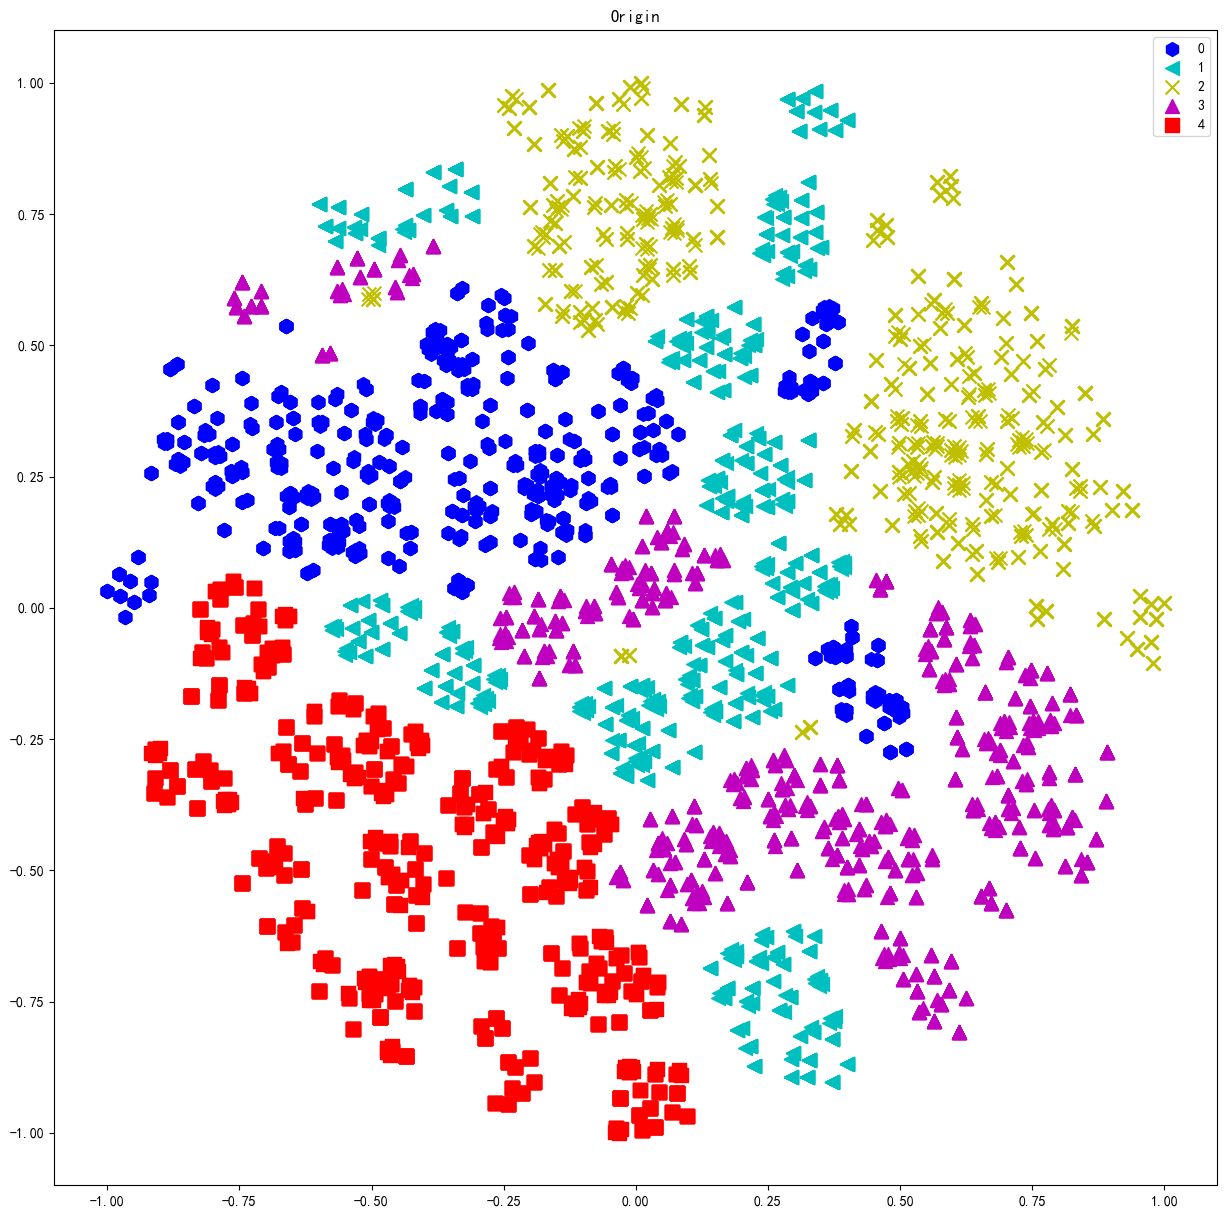

In [3]:
plt_tsne2d(data_X, data_y, title="Origin")

经过 RENN 后: 样本数：7091 耗时:11.660
类别为 0 的样本数: 1490
类别为 1 的样本数: 1433
类别为 2 的样本数: 1345
类别为 3 的样本数: 1323
类别为 4 的样本数: 1500
    


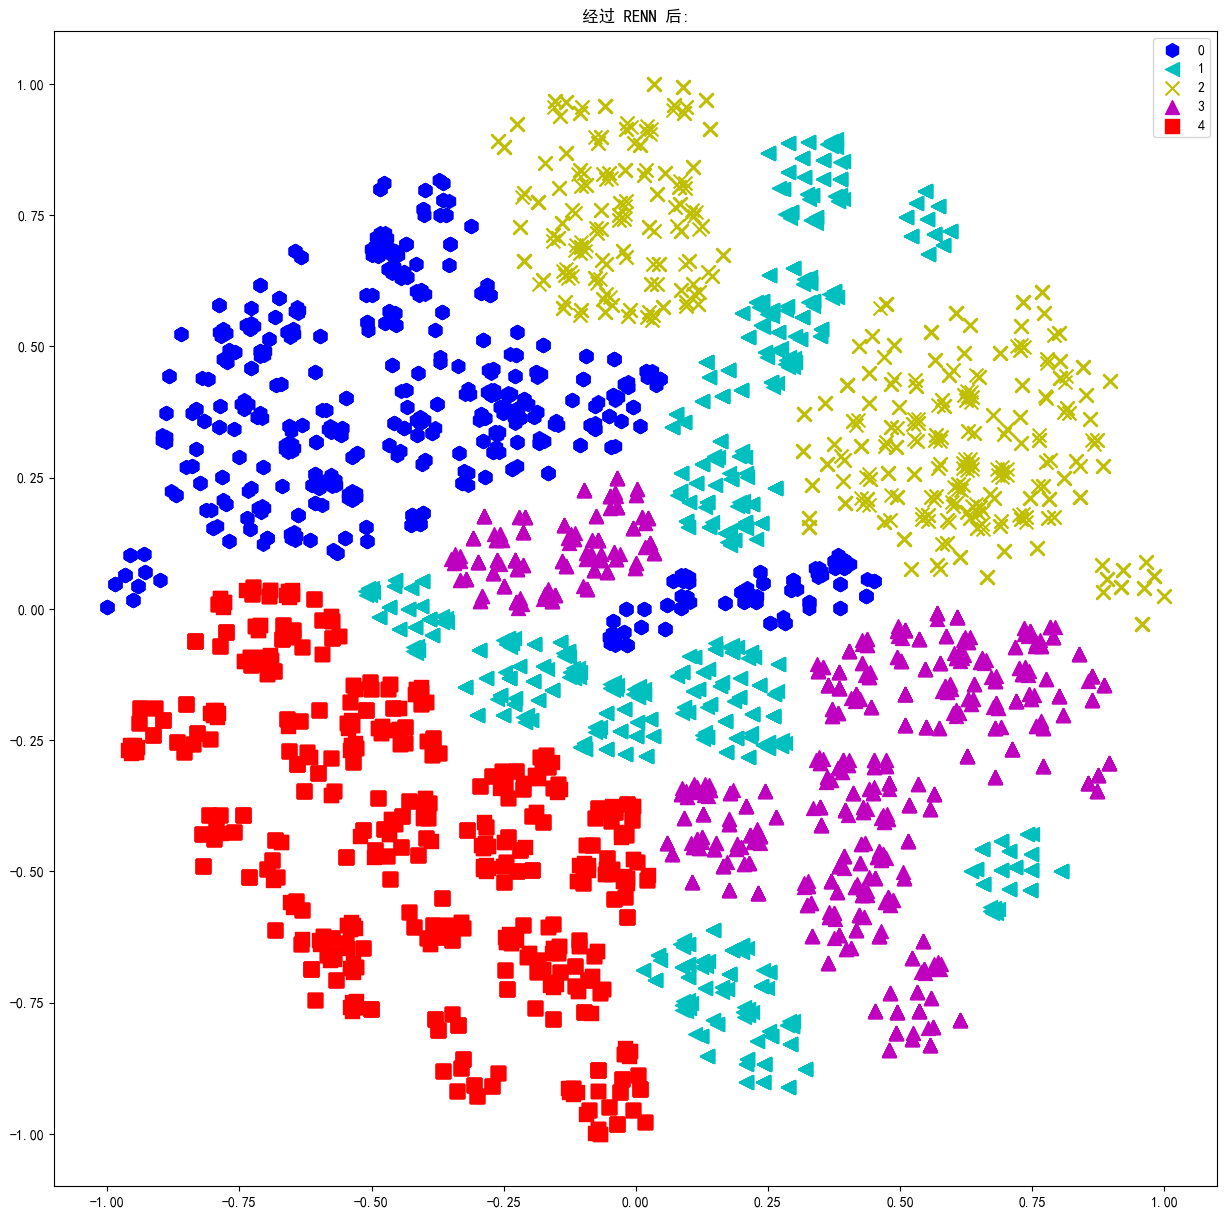

In [4]:
RENN = RepeatedEditedNearestNeighbours(sampling_strategy='all', n_neighbors=50)

start_time = time.time()


  
original_indices = np.arange(len(data_path))
    
before_data_x = data_X
data_X, data_y = RENN.fit_resample(data_X, data_y)
    
kept_indices = np.array([np.where((before_data_x == x).all(axis=1))[0][0] for x in data_X])
data_path = [data_path[i] for i in kept_indices]


cost_time = time.time() - start_time

print(f"经过 RENN 后: 样本数：{len(data_path)} 耗时:{cost_time:.3f}")
print(f"\
类别为 0 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 1 的样本数: {np.count_nonzero(data_y == 1)}\n\
类别为 2 的样本数: {np.count_nonzero(data_y == 2)}\n\
类别为 3 的样本数: {np.count_nonzero(data_y == 3)}\n\
类别为 4 的样本数: {np.count_nonzero(data_y == 4)}\n\
    ")

plt_tsne2d(data_X, data_y, title=f"经过 RENN 后:")

经过 RENN + IHT 后: 样本数：6615 耗时:7.590
类别为 0 的样本数: 1323
类别为 1 的样本数: 1323
类别为 2 的样本数: 1323
类别为 3 的样本数: 1323
类别为 4 的样本数: 1323
    


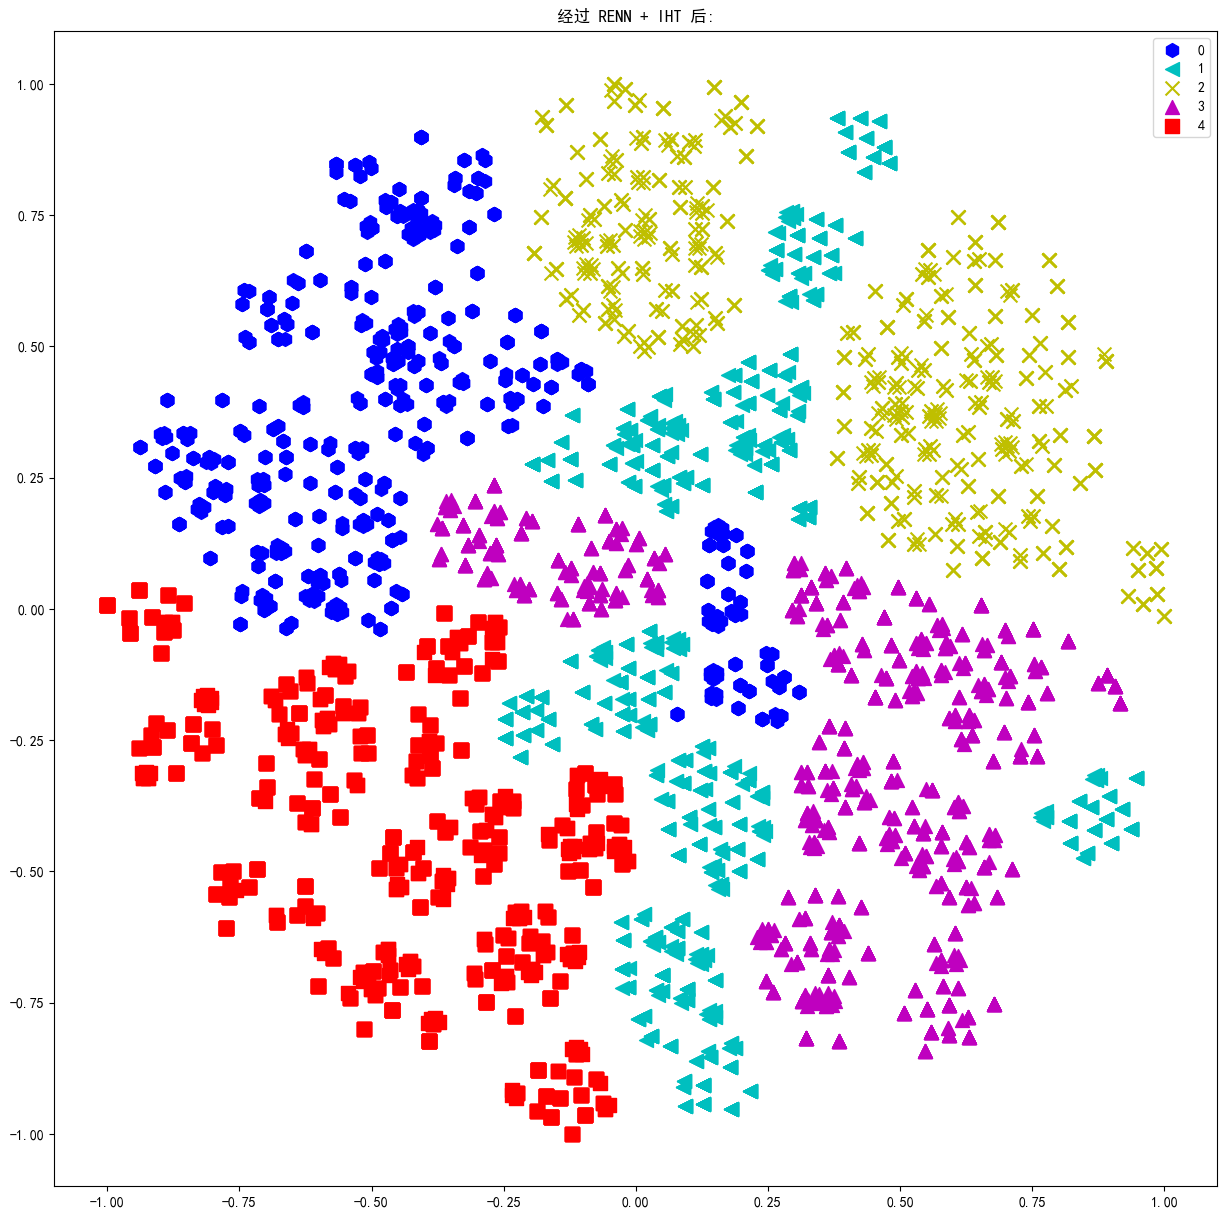

In [5]:
IHT = InstanceHardnessThreshold(sampling_strategy='all', estimator=LogisticRegression(), cv=10, random_state=42)

start_time = time.time()

original_indices = np.arange(len(data_path))
before_data_x = data_X
data_X, data_y = IHT.fit_resample(data_X, data_y)

cost_time = time.time() - start_time

kept_indices = np.array([np.where((before_data_x == x).all(axis=1))[0][0] for x in data_X])
data_path = [data_path[i] for i in kept_indices]

print(f"经过 RENN + IHT 后: 样本数：{len(data_path)} 耗时:{cost_time:.3f}")
print(f"\
类别为 0 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 1 的样本数: {np.count_nonzero(data_y == 1)}\n\
类别为 2 的样本数: {np.count_nonzero(data_y == 2)}\n\
类别为 3 的样本数: {np.count_nonzero(data_y == 3)}\n\
类别为 4 的样本数: {np.count_nonzero(data_y == 4)}\n\
    ")

plt_tsne2d(data_X, data_y, title=f"经过 RENN + IHT 后:")

经过 RENN + IHT + CC 后: 样本数：6615 耗时:16.021
类别为 0 的样本数: 1323
类别为 1 的样本数: 1323
类别为 2 的样本数: 1323
类别为 3 的样本数: 1323
类别为 4 的样本数: 1323
    


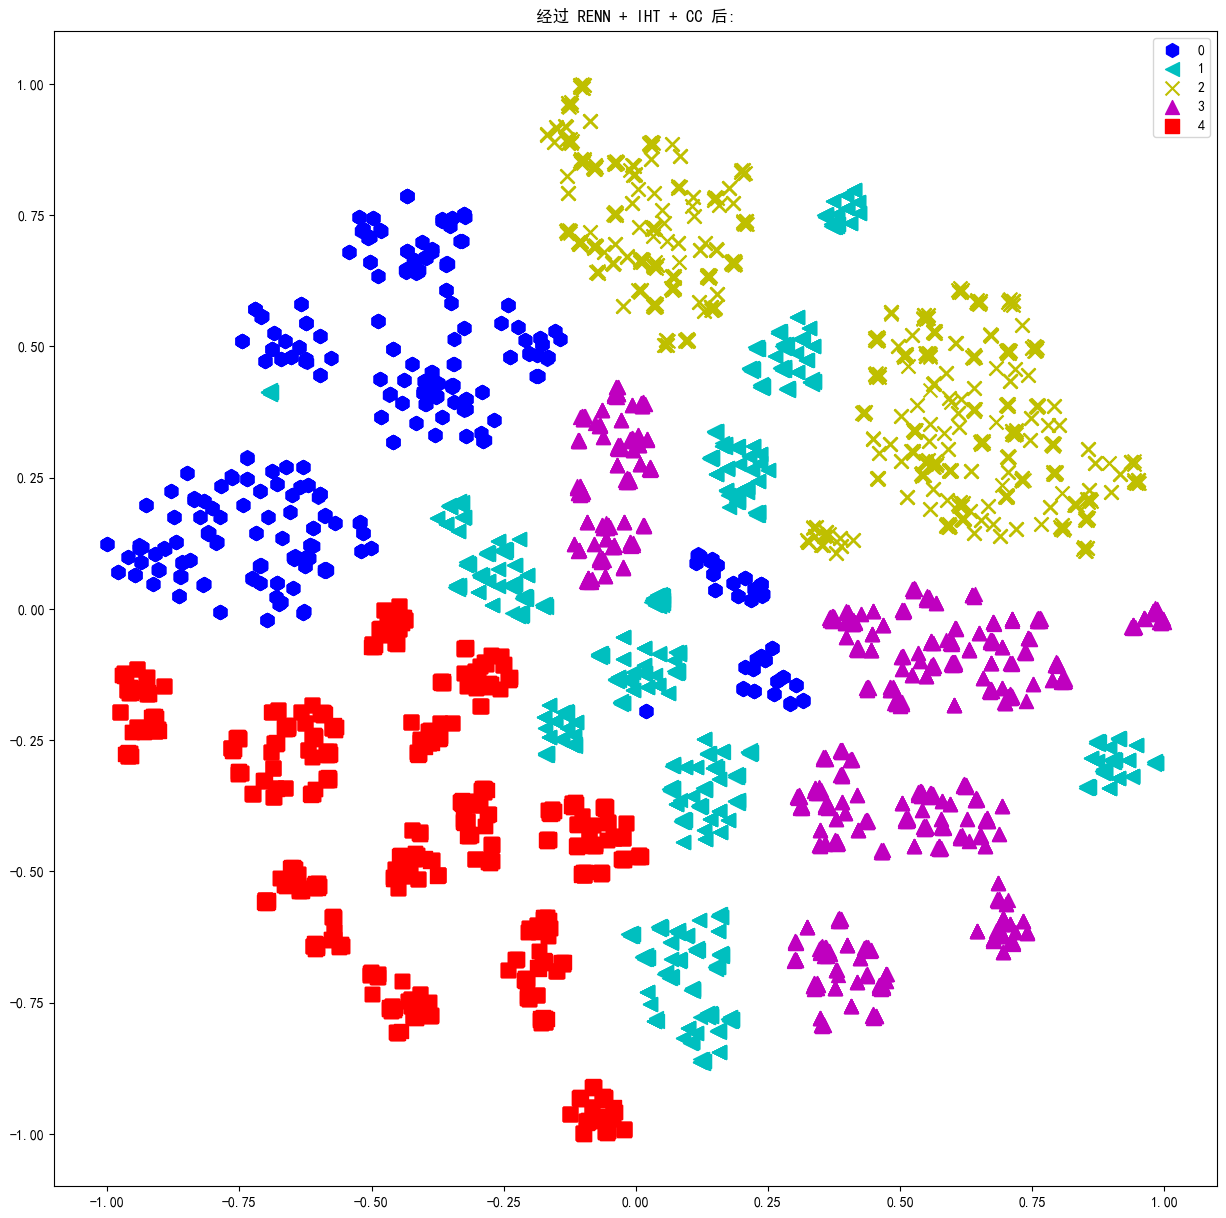

In [6]:
CC = ClusterCentroids(sampling_strategy='auto', estimator=MiniBatchKMeans(n_init=1, random_state=0), voting='auto') # 

start_time = time.time()
original_indices = np.arange(len(data_path))
before_data_x = data_X
data_X, data_y = CC.fit_resample(data_X, data_y)

# kept_indices = np.array([np.where((before_data_x == x).all(axis=1))[0][0] for x in data_X])
# kept_indices = np.array([np.where((before_data_x == x).all(axis=1))[0][0] for x in data_X])
# data_path = [data_path[i] for i in kept_indices]

cost_time = time.time() - start_time

print(f"经过 RENN + IHT + CC 后: 样本数：{len(data_y)} 耗时:{cost_time:.3f}")
print(f"\
类别为 0 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 1 的样本数: {np.count_nonzero(data_y == 1)}\n\
类别为 2 的样本数: {np.count_nonzero(data_y == 2)}\n\
类别为 3 的样本数: {np.count_nonzero(data_y == 3)}\n\
类别为 4 的样本数: {np.count_nonzero(data_y == 4)}\n\
    ")

plt_tsne2d(data_X, data_y, title=f"经过 RENN + IHT + CC 后:")